# Found methods
1) To control the robot in from pyrep, change the target node. And it would follow it.
<br>2) Perform regular checks using pyrep and update way_points regularly
<br>3) Create a function which steps one simulation and updates the waypoint via checking whether fish is near the waypoint


<br> The above methods are required for better performance


# Issues
<br> 1. The path is not consistent. It passes through way-points
<br> Solved: Rounding gcost to two decimal places removes the minute difference in gcosts.
<br> 2. Scanning is not proper
<br> Solved: rd, ru, cl,cr were interchanged due to misinterpretation. 
<br> Goal condition is making the program slow
<br> Look for head on collision. Collision is can happen behind the robot, if obstacle has highspeed and goes for headon collision


# This version info
1) The start point plot hasbeen added. And edge cost are no longer updated by the getchildren one. This solved the problem.
<br> 2) The limit of way-point to check is a issue currently
<br> 3) The scanning rectangle centre is some distance(window size) ahead of the robot facing. 
<br> 3.1) This is dstar 1st version. 2nd version has issues. 
<br> 4) Waypoints check = int(win/1.2)
<br> 5) The way-point check is not checking the waypoints instead some other point. This needs to be solved. - seems solved
<br> 6) made update map efficient
<br> 7) Uses transformation matrices for next state.
<br> 8) Make changes in previous version state[2] = 2*math.pi+state[2] #if theta is negative. get the correct theta.changes. Please its positive sign not neg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time
import math
import random
from IPython.display import clear_output
import sys

import heapq as hq #for priority que


import threading #for simulating and multipath program|ming


# initialise Vrep parameters
from pyrep import PyRep
pr = PyRep()
from pyrep.objects.object import Object
from pyrep.objects.joint import Joint
from pyrep.objects.shape import Shape
from pyrep import const



ImportError: libcoppeliaSim.so.1: cannot open shared object file: No such file or directory

In [6]:
# state is np array (x,y,theta) 
# action is np array (dx,dy,dtheta)



def get_next_state_old(state1,action):
    
    state = np.copy(state1) # create the new state
    
    state[0] = state[0] + action[0]*math.cos(state[2]) - action[1]*math.sin(state[2])#get x
    state[1] = state[1] + action[0]*math.sin(state[2]) + action[1]*math.cos(state[2])#get y
    if(state[2]<0):
        state[2] = 2*math.pi+state[2] #if theta is negative. get the correct theta.changes. Please
    state[2] = (state[2] + action[2])%(2*math.pi) # get theta
    
    return state

def get_next_state(state1,action):
    
    state = np.copy(state1) # create the new state
    atm = np.identity(3,dtype = float)
    atm[0,0] = np.cos(action[2]); atm[0,1] = -np.sin(action[2]); atm[0,2] = action[0];
    atm[1,0] = np.sin(action[2]); atm[1,1] = np.cos(action[2]);  atm[1,2] = action[1];
    #print(atm)
    aitm =  np.linalg.inv(atm)
    
    tm = np.identity(3,dtype = float)
    tm[0,0] = np.cos(state[2]); tm[0,1] = -np.sin(state[2]); tm[0,2] = state[0];
    tm[1,0] = np.sin(state[2]); tm[1,1] =  np.cos(state[2]); tm[1,2] = state[1];
    #print(tm)
    new_tm = np.dot(tm,aitm) #get new transformation matrix
    #print(new_tm)
    state[0] = new_tm[0,2]
    state[1] = new_tm[1,2] #get the states
    
  
    state[2] = (state[2] - action[2])
   # print("2.5",state[2])
    if(state[2]<0):
        state[2] = 2*math.pi+state[2] #if theta is negative. get the correct theta. Again do the same thing
    #print("3",state[2])
    state[2]=state[2]%(2*math.pi) # get theta
   # print("4",state[2])
    #print(state[2])
    
    
    return state

def compute_cost(m1,m2): # can be used to compute to distance between two  vectors
    dm = m1-m2 # this creates a new array here
    return math.sqrt(dm[0]*dm[0]+dm[1]*dm[1])

def get_flow_index(orientation,flow_dir): # get the flow index with respect to robot
    # get the flow relative to robot
    rel_flow = np.zeros((2,),dtype=float)
    rel_flow[0] = flow_dir[0]*math.cos(orientation) + flow_dir[1]*math.sin(orientation)
    rel_flow[1] = -flow_dir[0]*math.sin(orientation) + flow_dir[1]*math.cos(orientation)
    # get the flow index
    fl = [1,1] # this [1,1] to get the index for [0,0] flow
    max_f = abs(max(rel_flow,key=abs)) #get the maximum abs
    if(max_f!=0): #if there are no double zeros
            fl[0] = round(rel_flow[0]/max_f) + 1 
            fl[1] = round(rel_flow[1]/max_f) + 1 
    return 3*fl[0] + fl[1] 

In [7]:
df=pd.read_csv('action_space.csv')# read the csv for state action pairs
df

,x,y,theta
0,1.0392,-0.6,-0.130
1,1.2000,0.0,0.240
2,1.0392,0.6,0.780
3,1.0392,-0.6,-0.630
4,1.2000,0.0,-0.130
5,1.0392,0.6,0.640
6,1.0392,-0.6,-0.860
7,1.2000,0.0,-0.490
8,1.0392,0.6,0.266
9,1.0392,-0.6,-0.580


#process the action space for d*lite for processing
r,c=df.shape
for i in range(r):
    x = df.iloc[i,0]
    y = df.iloc[i,1]
    th = df.iloc[i,2]
    s = np.sin(math.pi+th)
    c = np.cos(math.pi+th)
    T = np.identity(3,dtype=float)
    R = np.array(((c,-s),(s,c)))
    T[0:2,0:2]=R
    T[0,2]=x
    T[1,2]=y
    it = np.linalg.inv(T)
    df.iloc[i,0]=it[0,2]
    df.iloc[i,1]=it[1,2]
    df.iloc[i,2]=-th
    

In [4]:
df

,x,y,theta
0,1.0392,-0.6,-0.130
1,1.2000,0.0,0.240
2,1.0392,0.6,0.780
3,1.0392,-0.6,-0.630
4,1.2000,0.0,-0.130
5,1.0392,0.6,0.640
6,1.0392,-0.6,-0.860
7,1.2000,0.0,-0.490
8,1.0392,0.6,0.266
9,1.0392,-0.6,-0.580


In [5]:
actions = df.values # convert the csv to numpy array , sliced vectors are diminesio (3,null)

In [6]:
#define node class and helper functions

gmag = 1.2 # the spherical step size is 1.2
flow = [0,0]
class node:  # this class uses global variable and hence global vars must be initialised first before calling
    def __init__(self,parent,state):
        self.parent = parent #initially set to zero
        self.state = state  # store the states and parents
        self.g_cost = float('inf') #Set infinity  as per D*Lite
        self.rhs = float('inf')
        self.children = [0]*3 #set the three childrens although these are pointers
        
        #keyself = [key,u_index,object] which is stored in U
        # key = [min(g,rhs)+h;min(g,rhs)]
        self.keyself=0
        
        self.updateno = 0
        
        self.is_U=False #to find out whether it is in open list or not.
        
        #self.edcost_pc = float('inf') #edge cost currently infinity
        self.edcost_pc = 1.2# edge cost currently 1.2 parent to children

    def __str__(self):
        return "state-> "+str(self.state[0])+", "+str(self.state[1])+", "+str(self.state[2]*180/math.pi)+", rhs-> "+str(self.rhs)+" gcost- "+str(self.g_cost)

        
def flush_grid():
    global grid #refere to the global
    for i in range(range_x):
        for j in range(range_x):
            for k in range(range_th):
                cnode = grid[i][j][k]
                cnode.parent = 0 #initially set to zero
                cnode.g_cost = float('inf') #Set infinity  as per D*Lite
                cnode.rhs = float('inf')
                #keyself = [key,u_index,object] which is stored in U
                # key = [min(g,rhs)+h;min(g,rhs)]
                cnode.keyself=0
                cnode.updateno=0
                cnode.is_U=False #to find out whether it is in open list or not.

                #self.edcost_pc = float('inf') #edge cost currently infinity
                cnode.edcost_pc = 1.2# edge cost currently 1.2

                
class rectangle:
    def __init__(self,x,y,height,width):
        #x is the lowest point irrespective of the quadrant. Thus next corner x would be x + width. 
        self.x = x
        self.y = y
        self.height = height
        self.width = width
    def __str__(self):
        return str(self.x)+", "+str(self.y)+", "+str(self.width)+", "+str(self.height)
    
#get grid node. 
def grid_node(pose):
    global s_x,s_th,grid #refrer to global vars
    if(pose[0]>=15 or pose[1]>=15):
        return sys.exit('x and y values are above 15')
    return grid[int(s_x*pose[0])][int(s_x*pose[1])][int(s_th*pose[2])]


In [7]:
range_x = 75
range_th = 16

s_x = range_x/15 #cordinate multiplier for co-ordinates
s_th = range_th/(2*math.pi) #multipliers for grid indices for orientation discretised in range_th values

In [8]:
grid=[] #create a 3D array of node objects. 75x75x16 ,... [n,n,n,n,n,,n,,n,,n,n,]
for i in range(range_x):
    x=[]
    for j in range(range_x):
        th=[]
        for k in range(range_th):
            gstate = np.array([i/s_x,j/s_x,k/s_th]) 
            th.append(node(0,gstate)) #add the node attributes #states are added here
        x.append(th)
    grid.append(x)        
           

In [9]:
#create children for grid nodes 
#pre_computation for faster end computation
flow = [0,0]
gu = 0
for i in range(range_x):
    for j in range(range_x):
        for k in range(range_th):
            
            cnode = grid[i][j][k]
            cc = []
            state = cnode.state
            f_index = get_flow_index(state[2],flow) # get the flow index from orientation and flow
            for m in range(3): #stupid rename it as m. dont use "i" everywhere. spent 3hrs debugging the silly mistake
                        action = actions[(3*f_index+m),:]  # get the action for respective floe
                        child_state = get_next_state(state,action) #get the next state for applied action
                        
                        if(child_state[0]>=15 or child_state[1]>=15 or child_state[0]<0 or child_state[1]<0):
                            cc.append(0) #append 0 to children, this keeps no of children same. 
                        else: 
                            child_node = grid_node(child_state) #get the associated node
                            cc.append(child_node)
     
            cnode.children = cc #set the children
                
                
                                
def eudis(p1,p2):
    pp = p1-p2
    return math.sqrt(np.sum(np.square(pp)))              
           

In [8]:
#create the environment
# launch the coppeliasim
pr.launch('eel_for_presentation.ttt', headless=False) 
pr.step()
action_hull = []
#hull =  Object.get_object('hull')
action0 = Object.get_object('action0')
action1 = Object.get_object('action1')
action2 = Object.get_object('action2')



hull = Object.get_object('hull')

#action_hull.append(hull)
action_hull.append(action0)
action_hull.append(action1)
action_hull.append(action2)

action_hull.reverse()

#Goal
goal_ob = Object.get_object('Goal')


#eel links 
wpoint = Object.get_object('waypoint')

link = Object.get_object('link4')
links = [Object.get_object('link4'),Object.get_object('link3'),Object.get_object('link2'),Object.get_object('link1'),Object.get_object('link0')]


RuntimeError: Handle action0 does not exist.

In [10]:
sim = True
gtime = 0
def dumrum():
    global sim,gtime
    gtime = 0
    while(sim):
        pr.step()
        gtime+=0.05
    

In [41]:
#obstacle features
grid_size = 13
no_of_obstacles = 10
obs_dia = 2.3
obs_gap = 1.5

obs_count = no_of_obstacles-1
obs_points=[]
while(obs_count>0):
    #get a random point
    #obs=np.random.randint(grid_size,size=(3,))
    
    obs = np.zeros((3,),dtype=float)
    obs[1] = random.randint(1, grid_size)
    obs[2] = 0.5
    obs[0] = random.randint(1, grid_size)  
    
    s1=0
    if(len(obs_points)==0): #first time go through gere
           obs_points.append(obs)
    else:
        for opoint in obs_points:
            if(eudis(obs,opoint)<(obs_dia+obs_gap)): #check the inter distance of obstacles
                s1=1
                break
            
        if(s1==0): #you put s1==1 thats why it was wroung
            obs_points.append(obs)
           
            obs_count-=1
           
    
    
           
       
    
obs_points  

KeyboardInterrupt: 

In [13]:
'''
#create the shapes
for opoint in obs_points:
    Shape.create(const.PrimitiveShape.SPHERE,[obs_dia,obs_dia,obs_dia],1.0,False, False,False,False,True, True, opoint,None,None)
print("done")
'''

'\n#create the shapes\nfor opoint in obs_points:\n    Shape.create(const.PrimitiveShape.SPHERE,[obs_dia,obs_dia,obs_dia],1.0,False, False,False,False,True, True, opoint,None,None)\nprint("done")\n'

In [88]:
#get the sphere objects
num_obs = 11
spheres = []
spheres.append(Object.get_object('Sphere'))
l = num_obs-1
for i in range(l):
    spheres.append(Object.get_object('Sphere'+str(i)))
    print('Sphere'+str(i))
for s in spheres:
    print(s.get_position())

Sphere0
Sphere1
Sphere2
Sphere3
Sphere4
Sphere5
Sphere6
Sphere7
Sphere8
Sphere9
[7.82499981 4.92500305 0.49999928]
[4.9499979  2.52499938 0.49999905]
[11.22500134  5.12500048  0.5       ]
[ 6.20000029 11.0249958   0.49999952]
[0.72499883 7.74999952 0.49999952]
[9.20000267 9.90000153 0.49999976]
[8.95000076 1.52499998 0.49999881]
[3.32499766 9.20000172 0.49999928]
[7.52499866 8.15000057 0.5       ]
[4.25000095 4.95000076 0.5       ]
[12.29999924  8.94999981  0.5       ]


In [57]:
num_obs=14
safe_dis=0.2
obs_dia=1
def destroyspheres():
    global spheres

    if(len(spheres)==0):
        return
    else:
        print("here")
        for s in spheres:
            s.remove()
            spheres = []

In [16]:
#obstacle features
def getobsloc(dia,num):
    grid_size = 13
    no_of_obstacles = num
    obs_dia = dia
    obs_gap = 1.5

    obs_count = no_of_obstacles-1
    obs_points=[]
    while(obs_count>0):
        #get a random point
        #obs=np.random.randint(grid_size,size=(3,))

        obs = np.zeros((3,),dtype=float)
        obs[1] = random.randint(1, grid_size)
        obs[2] = 0.5
        obs[0] = random.randint(1, grid_size)  

        s1=0
        if(len(obs_points)==0): #first time go through gere
               obs_points.append(obs)
        else:
            for opoint in obs_points:
                if(eudis(obs,opoint)<(obs_dia+obs_gap)): #check the inter distance of obstacles
                    s1=1
                    break

            if(s1==0): #you put s1==1 thats why it was wroung
                obs_points.append(obs)

                obs_count-=1
    return obs_points
    
    

In [17]:

def generate_spheres(dia,num):
   
    
    #create spheres as well as 
    global spheres
    obs_points = getobsloc(dia,num)
    #now create shape
    for opoint in obs_points:
        Shape.create(const.PrimitiveShape.SPHERE,[dia,dia,dia],1.0,False, False,False,False,True, True, opoint,None,None)
    spheres = []
    spheres.append(Object.get_object('Sphere'))
    l = len(obs_points)-1
    for i in range(l):
        spheres.append(Object.get_object('Sphere'+str(i)))
        #print('Sphere'+str(i))

    for sphere in spheres:
        sphere.set_collidable(True) #set all the spheres collidable
        sphere.set_dynamic(True)
        sphere.set_respondable(True)


    for action_path in action_hull:
        action_path.set_collidable(False) #initially set false. Then when required we only set one

    hull.set_collidable(False) #we set this uncollidable
    

In [18]:
for sphere in spheres:
    sphere.set_collidable(True) #set all the spheres collidable



for action_path in action_hull:
    action_path.set_collidable(False) #initially set false. Then when required we only set one

hull.set_collidable(False) #we set this uncollidable
    

In [19]:
#define helper functions for analysis and Dlite
def get_rot_array(state):
    rot_array = np.identity(4,dtype=float)
    rot_array[0,0]=math.cos(state[2]); rot_array[0,1]=-math.sin(state[2]);
    rot_array[1,0]=math.sin(state[2]); rot_array[1,1]= math.cos(state[2]);
   
    rot_array[0,3]=state[0]
    rot_array[1,3]=state[1]
    rot_array[2,3]=0.5    #since its floating  in water
    return rot_array

def h_cost(m1,m2): # can be used to compute to distance between two  vectors
    dm = m1-m2 # this creates a new array here
    return math.sqrt(dm[0]**2+dm[1]**2)


def calckey(node_state):
    global start_node
    minn = min(node_state.g_cost,node_state.rhs)
    return [minn+h_cost(start_node.state,node_state.state),minn]   #stupid 

def prepare_goal(force_orientation):
    global U,u_index,goal_node,goal_or_nodes
    u_index=0
    if(force_orientation):
        #That means robot should reach in that specific orientation only. Dont forget to change to compare the states
        goal_node.rhs = 0 #set rhs =0 for goal node
        kself = [calckey(goal_node),u_index,goal_node]
        goal_node.keyself = kself #self reference d
        hq.heappush(U,kself) #add goal node and key in U list
        goal_node.is_U = True
        u_index+=1
    else:
        for gnode in goal_or_nodes:
            gnode.rhs=0
            kself = [calckey(gnode),u_index,gnode]
            hq.heappush(U,kself) #add goal node and key in U list
            gnode.keyself = kself #add the keyself also
            u_index+=1
            
            
            
def init(force_orientation):
    #refer to globals
    global U
    global xrr,yrr
    global u_index
    global goal_node
    global start_node
    global start_pose,all_nodes,spheres_pos,spheres_vel,xo,yo,gx,gy,goal_or_nodes, goal_pose, goal_node, goal_ob
    #initialise
    U=[]
    goal_ob.set_position([gx,gy,0.5]) #set position of goal in coppeliasim
    all_nodes = [] #damn I forgot to empty this during initialisation. All the mess for now
    start_pose = np.array([1,1,math.pi/4]) #the start location of
    start_node = grid_node(start_pose)

    goal_pose = np.array([gx,gy,math.pi/4])
    goal_node = grid_node(goal_pose) #get the grid node from pose
    
    goal_or_nodes = []
    
    #stupid discretising angular space in 36 while grid space is max 16. lol
    #goal_angles =  list(10*j for j in range(36)) #goal angle in degrees  #goal angle in degrees
    goal_angles = list(30*j for j in range(11))
    goal_angles.extend([45,135,225,315])
    for goal_angle in goal_angles:
        goal_or_nodes.append(grid_node(np.array([gx,gy,math.pi/180*goal_angle]))) #store the goal nodes


    prepare_goal(force_orientation)

    spheres_pos = []
    spheres_vel = []
    

    xrr = []
    yrr = []
    xo=[];yo=[];
    xrr.append(goal_node.state[0])
    yrr.append(goal_node.state[1])
    
    #load the spheres
    for sphere in spheres:
        spheres_pos.append(sphere.get_position())
        spheres_vel.append(sphere.get_velocity()[0])

    
num_obs = 6     
def set_obstacles():
    global spheres,gx,gy,num_obs,safe_dis,obs_dia
    #obstacle features
    grid_size = 14
    no_of_obstacles = num_obs

    obs_gap = safe_dis

    obs_count = no_of_obstacles-1
    obs_points=[]
    while(obs_count>0):
        #get a random point
        #obs=np.random.randint(grid_size,size=(3,))

        obs = np.zeros((3,),dtype=float)
        obs[1] = random.randint(3, grid_size-3)
        obs[2] = 0.5
        obs[0] = random.randint(3, grid_size-3)  

        s1=0
        if(len(obs_points)==0): #first time go through gere
               obs_points.append(obs)
        else:
            for opoint in obs_points:
                if(eudis(obs,opoint)<(obs_dia+obs_gap)): #check the inter distance of obstacles
                    s1=1
                    break
                    

            if(s1==0): #you put s1==1 thats why it was wroung
                obs_points.append(obs)
                #print(obs)
                obs_count-=1



    for i in range(len(spheres)):
        spheres[i].set_position(obs_points[i])


def create_obstacles():
    global spheres,gx,gy
    #obstacle features
    grid_size = 14
    no_of_obstacles = 6
    obs_dia = 2.3
    obs_gap = 0.5

    obs_count = no_of_obstacles-1
    obs_points=[]
    while(obs_count>0):
        #get a random point
        #obs=np.random.randint(grid_size,size=(3,))

        obs = np.zeros((3,),dtype=float)
        obs[1] = random.randint(3, grid_size-3)
        obs[2] = 0.5
        obs[0] = random.randint(3, grid_size-3)  

        s1=0
        if(len(obs_points)==0): #first time go through gere
               obs_points.append(obs)
        else:
            for opoint in obs_points:
                if(eudis(obs,opoint)<(obs_dia+obs_gap)): #check the inter distance of obstacles
                    s1=1
                    break
                    

            if(s1==0): #you put s1==1 thats why it was wroung
                obs_points.append(obs)
                #print(obs)
                obs_count-=1



    for i in range(len(spheres)):
        spheres[i].set_position(obs_points[i])
                    

In [20]:
#initialise
U=[]


gx = 12; gy=12; 

all_nodes = [] #damn I forgot to empty this during initialisation. All the mess for now
start_pose = np.array([1,1,math.pi/4]) #the start location of
start_node = grid_node(start_pose)



goal_pose = np.array([gx,gy,math.pi/4])
goal_node = grid_node(goal_pose) #get the grid node from pose


goal_or_nodes = [] #define list of goal nodes to look as goal as indepent of orientation.
#stupid discretising angular space in 36 while grid space is max 16. lol
#goal_angles =  list(10*j for j in range(36)) #goal angle in degrees  #goal angle in degrees
goal_angles = list(30*j for j in range(11))
goal_angles.extend([45,135,225,315])
for goal_angle in goal_angles:
    goal_or_nodes.append(grid_node(np.array([gx,gy,math.pi/180*goal_angle]))) #store the goal nodes
    

prepare_goal(False)



xrr = []
yrr = []

xrr.append(goal_node.state[0])
yrr.append(goal_node.state[1])



spheres_pos=[]
spheres_vel=[]

#load the spheres
for sphere in spheres:
    spheres_pos.append(sphere.get_position())
    spheres_vel.append(sphere.get_velocity()[0])
    


In [21]:

def isInside(circle_x, circle_y, rad, x, y): 
      
    # Compare radius of circle 
    # with distance of its center 
    # from given point 
    
    if ((x - circle_x) **2 + 
        (y - circle_y) **2 <= rad **2): 
        return True; 
    else: 
        return False; 
    
        

In [22]:
eel_vel = 0.125
def check_collision_w(curr_node):
    global obs_dia,eel_vel,spheres,safe_dis
    hull_size = 0.35+safe_dis #size of robot
    state = curr_node.state
    s1 = state[0] #this is to avoid editing the object
    s2 = state[1]
    for sphere in spheres:
        pos = sphere.get_position()
        vel = sphere.get_velocity()
        t = h_cost(start_node.state,state)/eel_vel #get the minimum time to reach
        #modify the state now
        s3=s1-vel[0][0]*t
        s4=s2-vel[0][1]*t #such that we can apply collision detection on the transformed point
        rad = obs_dia/2+hull_size
        if(isInside(pos[0],pos[1],rad,s3,s4) or isInside(pos[0],pos[1],rad,s1,s2)): #This combination incorporates uncertainity
            return True
        '''
        if(isInside(pos[0],pos[1],rad,s3,s4)):
            return True
        '''
    return False
    

    
    
    
    
    

In [23]:
eel_vel = 0.125
def check_collision_edge(curr_node):
    global obs_dia,eel_vel,spheres,safe_dis
    hull_size = 0.35 + safe_dis# half size of robot
    
    state = curr_node.state
    s1 = state[0] #this is to avoid editing the object
    s2 = state[1]
    for sphere in spheres:
        pos = sphere.get_position()
        vel = sphere.get_velocity()
        t = h_cost(start_node.state,state)/eel_vel #get the minimum time to reach
        #modify the state now
        s3=s1-vel[0][0]*t
        s4=s2-vel[0][1]*t #such that we can apply collision detection on the transformed point
        rad = obs_dia/2+hull_size
        if(isInside(pos[0],pos[1],rad,s3,s4) or isInside(pos[0],pos[1],rad,s1,s2)):
            return float('inf')
        '''
        if(isInside(pos[0],pos[1],rad,s3,s4)):
            return float('inf')
        '''
    return 1.2
    

    
    
    
    
    

In [24]:
eel_vel = 0.125
def check_collision(curr_node):
    global obs_dia,eel_vel,spheres,safe_dis
    hull_size = 0.35 + safe_dis# half size of robot
    
    state = curr_node.state
    s1 = state[0] #this is to avoid editing the object
    s2 = state[1]
    for sphere in spheres:
        pos = sphere.get_position()
        vel = sphere.get_velocity()
        t = h_cost(start_node.state,state)/eel_vel #get the minimum time to reach
        #modify the state now
        s3=s1-vel[0][0]*t
        s4=s2-vel[0][1]*t #such that we can apply collision detection on the transformed point
        rad = obs_dia/2+hull_size
        if(isInside(pos[0],pos[1],rad,s3,s4) or isInside(pos[0],pos[1],rad,s1,s2)):
            return True
        '''
        if(isInside(pos[0],pos[1],rad,s3,s4)):
            return True
        '''
    return False
    

    
    
    
    
    

In [25]:
safe_dis+0.35

0.55

In [26]:
def goal_condition(curr_node):
    curr_state = curr_node.state
    
    if(eudis(curr_state[0:2],start_pose[0:2])<0.6 and (abs(curr_state[2]-start_pose[2])<0.7)):
        return True and not check_collision_w(curr_node)
    else:
        return False
    

In [27]:
def update_vertex(current_node):  #worst case time complexity (N+log(N))
    
    #update the rhs value. and if not consistent then insert it in U with new key. So new rhs is registered
    global u_index,U,goal_node,nn
    nn = current_node
    parent = current_node.parent
    if(parent==0):
        return
        #as it doesn't have a parent. its rhs is same=0
    if(current_node!=goal_node):
        current_node.rhs = parent.rhs + current_node.edcost_pc  #rhs + edgecost
        
        #to avoid a problem which is poping of nodes which are near to robot than the one 
        #which needs to be poped when the nodes and robot lie in straight line
        # eg node 1 = gcost = 9.6, h = 2.4,    node 2 , gcost = 10.7999999 h = 1.2
        # node 1 fcost = 9.6+2.4 = 12     node2 fcost 10.79999+1.2=11.9999
        
        #print('update rhs',current_node.rhs,current_node.g_cost)
    if(current_node.is_U):
        #rhs is now updated. U list contains keys,rhs with old values.
        #keyself is only updated on node push.
        
        #for reducing memory size. we can use old rhs,,old gvalue value. And re-create old key value
        # This is at the expense of time complexity or computing the keys
        #
        
        U.remove(current_node.keyself) #this removes the self instance from list (N)
        current_node.is_U = False
        hq.heapify(U) #heapify the U again due to deletion log(N)
        
    if(current_node.g_cost!=current_node.rhs):
        kself = [calckey(current_node),u_index,current_node]
        #print(U)
        hq.heappush(U,kself) #push the new val in U . log(N)
        current_node.is_U = True #its now in U
        current_node.keyself = kself #update the reference
        u_index+=1

In [28]:
#generate_children
xo=[]
yo=[]
xx=[]
yy=[]
def get_children(current_node):
    
    global error,xo,yo
    
    state = current_node.state #get the pose of the robot
    
    
    children = [] #possible childrens
    cc = current_node.children #get all the children children


    for i in range(3):
         
        if(len(cc)!=3):
            print(current_node)
            print(len(cc))
            print(current_node.state)
            print(cc)
            error = current_node
        if(cc[i]==0):
            #its a null node. It was outside the grid. We skip it
            continue   
            
        child_node = cc[i]  
        '''
        if(child_node.edcost_pc == float('inf') ):  #this step is the major step which doesn't allow the tree to grow.
            #so this doesn't allow collision graph changes to go. Well we don't care na.
            #skip the colliding one. Don't add it.
            continue  #maybe don't add this dumbass. aaah just check for now.
            #print('is colliding')
            
            #this above skipping doesn't allow the node to be considered for graph update.
        
        '''
        #print(child_node.parent)
        if(child_node.parent==0): #reaching the node for the first time . Most important path of the algorithm
            child_node.parent = current_node
     
        else:
            if(child_node.rhs>(current_node.rhs+child_node.edcost_pc) and child_node.parent!=current_node): #if node is already present
                #check if it can become the child
                child_node.parent = current_node
                #child_node.edcost_pc = 1.2 # also this. no more setting this up. I think it should be removed.
                

        
        
        children.append(child_node)
        

    return children#return the possible childrens

In [62]:
flow = [0,0]
gu = 0
error = 0
def compute_shortest_path(): #version 2 . Worst time complextiy is 3(N+log(N))
    
    
    mh=1000000
    i=1
    global gu,U,u_index
    #while(U[0][0]<calckey(start_node) or start_node.rhs!=start_node.g_cost):
    while(len(U)!=0):
        
        #print("U here ------------------------------------------------------------------------------------------------------")
        #print("U here ------------------------------------------------------------------------------------------------------")
        
        #print_u()

        i+=1
        if(i%15000==0):
            return [False,i] #return failure
        #print("U list below")
        #for uu in U:
        #    print(uu[2])
            
        u = hq.heappop(U) #get the top element of priority quee
        u[2].is_U = False
        
        
        gu = u
        #print("popping ====================================================================================================")
        #print("poped ",u[2])
        

        #clear_output(wait=True)
        
        manhattan  = np.sum(np.abs(u[2].state[0:2]))-1
        #print(manhattan)
        if(mh>manhattan or i<10):
            #print(i,u[2].state)
            mh = manhattan
            
            #continue #wtf is this  :< this wasted my 5 days in debugging. Stupid start debugging from top not bottom.                    
      
        if(u[2].g_cost>u[2].rhs):
            #print(u,"u[2].gost>u[2].rhs skipping")
            u[2].g_cost = round(u[2].rhs,2) #this prevents error if there is infintesimally small
            # difference in fcosts of two nodes
            #u[2].g_cost = u[2].rhs use this if you wanna see why the rounding was done
            #generate children here. And set their parent as u[1]
            childs = get_children(u[2])
            #print("poped children")
            for child in childs:
                #print(child)
                update_vertex(child) #update the vertex of its children 3(N+log(N)) , this updates its rhs value.

        else:
            u[2].g_cost = float('inf') #its over consistent
            #print("poping children for inconsistency")
            #if(u[2].parent==0):
            #    continue
            update_vertex(u[2]) #update the parent also.
            childs = get_children(u[2])
            for child in childs:
                update_vertex(child) #update the vertex of its children 3(N+log(N))
                
        if(goal_condition(u[2]) and (u[2].rhs+u[2].g_cost)!=float('inf')):
            return [True,i] #success  
        
    return [False, i]      
        
            

In [81]:

xc = []
yc =[]
#changed nodes while colliding

#xo means changed node which are now open or collision free

#xc means colliding ::: xo means currently open
def plot_graph():
    global spheres_pos,spheres_vel,xo,yo,xw,yw,xx,yy,rec,pcount,start_pose,rec,xc,yc,gtime,nx,ny

    fig = plt.figure()
    axes = fig.add_subplot(111)
    #draw obstacles
    
    for pos,vel in zip(spheres_pos,spheres_vel):
        #pos = sphere.get_position()
        circle = plt.Circle((pos[0], pos[1]), obs_dia/2, color='gray')
        axes.add_patch(circle)
        #vel = sphere.get_velocity()
        axes.arrow(pos[0], pos[1],vel[0]*10,vel[1]*10, head_width=0.5, head_length=0.3, fc='k', ec='k')
    
    #print("rectangle is ",rec)
    rect = patches.Rectangle((rec.x, rec.y), rec.width, rec.height, linewidth=1, edgecolor='r', facecolor='none') 
    axes.add_patch(rect) #draw the concerened area

    #plot the waypoint path   
    axes.plot(xx,yy)

    #print("len xo",len(xo))
    
    #print("in plot",xo)
    axes.scatter([start_pose[0]],[start_pose[1]],150,'blue',label= 'start')
    axes.scatter(xw,yw,50,'red',label='way-point_collision') #plot waypoint collision
    axes.scatter([goal_pose[0]],[goal_pose[1]],150,'green')
    axes.scatter(xx,yy,30,'green',label='way-points')
    axes.scatter(nx,ny,5,'tan',label='non - trevarsable')
    nx = []
    ny = []
    
    axes.set_xlim([-2,30])
    axes.set_ylim([-2,15])
    leg = axes.legend(loc ="lower right");
    axes.set_aspect(aspect=1)
    plt.title("Scenario snap at " + str(round(gtime,2))+" sec")
    plt.savefig("Simulation_raw_results/"+str(pcount))
    pcount+=1
    
    plt.show()
    

In [ ]:

xc = []
yc =[]
#changed nodes while colliding

#xo means changed node which are now open or collision free

#xc means colliding ::: xo means currently open
def plot_graphh():
    global spheres_pos,spheres_vel,xo,yo,xw,yw,xx,yy,rec,pcount,start_pose,rec,xc,yc,gtime

    fig = plt.figure()
    axes = fig.add_subplot(111)
    #draw obstacles
    
    for pos,vel in zip(spheres_pos,spheres_vel):
        #pos = sphere.get_position()
        circle = plt.Circle((pos[0], pos[1]), obs_dia/2, color='gray')
        axes.add_patch(circle)
        #vel = sphere.get_velocity()
        axes.arrow(pos[0], pos[1],vel[0]*10,vel[1]*10, head_width=0.5, head_length=0.3, fc='k', ec='k')
    
    #print("rectangle is ",rec)
    rect = patches.Rectangle((rec.x, rec.y), rec.width, rec.height, linewidth=1, edgecolor='r', facecolor='none') 
    axes.add_patch(rect) #draw the concerened area

    #plot the waypoint path   
    axes.plot(xx,yy)

    #print("len xo",len(xo))
    
    #print("in plot",xo)
    axes.scatter([start_pose[0]],[start_pose[1]],150,'blue',label= 'start')
    axes.scatter(xw,yw,50,'red',label='way-point_collision') #plot waypoint collision
    axes.scatter([goal_pose[0]],[goal_pose[1]],150,'green')
    axes.scatter(xx,yy,30,'green',label='way-points')
    axes.scatter(xo,yo,5,'olive',label='became free')
    axes.scatter(xc,yc,5,'orange',label='became non-traversable')
    
    axes.set_xlim([-2,30])
    axes.set_ylim([-2,15])
    leg = axes.legend(loc ="lower right");
    axes.set_aspect(aspect=1)
    plt.title("Scenario snap at " + str(round(gtime,2))+" sec")
    plt.savefig("Simulation_raw_results/"+str(pcount))
    pcount+=1
    
    plt.show()
    

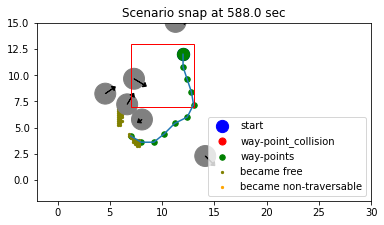

In [48]:
plot_graph()

In [32]:
def plot_obs():
    global xrr,yrr,spheres_pos,spheres_vel,xo,yo,xw,yw
    axes = plt.gca()
       #draw obstacles
    for pos,vel in zip(spheres_pos,spheres_vel):
        #pos = sphere.get_position()
        circle = plt.Circle((pos[0], pos[1]), obs_dia/2, color='gray')
        #axes.add_patch(circle)
        #vel = sphere.get_velocity()
        axes.arrow(pos[0], pos[1],vel[0]*10,vel[1]*10, head_width=0.5, head_length=0.3, fc='k', ec='k')
        plt.plot(xx,yy)
    #plt.scatter(xrr,yrr,5,'red')
    plt.scatter(xo,yo,1,'tan')
    plt.scatter(xw,yw,50,'red') #plot waypoint collision
    plt.scatter([goal_pose[0]],[goal_pose[1]],100,'green')
    axes.set_xlim([-2,15])
    axes.set_ylim([-2,15])
    axes.set_aspect(aspect=0.5)
    plt.savefig('Obs_1')
    plt.show()

In [33]:
def update_obmap():
    global spheres,spheres_pos,spheres_vel
    spheres_pos=[]
    spheres_vel=[]
    #load the spheres. This stores an image of the obstacles and lets the algorithm complete
    for sphere in spheres:
        spheres_pos.append(sphere.get_position())
        vel = sphere.get_velocity()
        spheres_vel.append(vel[0])
        
    

In [34]:
def get_waypoints(curr_node):
    global xx,yy
    w_nodes = [] #to store waypoint node pointers
    w_nodes.append(curr_node)
    xx = []
    yy = []

    while(curr_node.parent!=0):
        curr_node= curr_node.parent
        w_nodes.append(curr_node) #add the current node to the list
        xx.append(curr_node.state[0])
        yy.append(curr_node.state[1])
    return w_nodes #return the new way_nodes list
    

In [83]:
nx = []
ny = []

rec = rectangle(0,0,0,0) #define a rectangle
def update_map():
    global all_nodes,s_x,s_th,start_pose,xo,yo,rec,win,xc,yc
    c=0
    
    theta = start_pose[2] #get orientation.
    #bring the rectangle such that robot heading covers max area.
    x = rec.x
    y = rec.y
    #width = min(win+rx,13) - rec.x
    #height = min(win+ry,13) - rec.y
    #win is the halflength of the window
    #create a square 
    cl = int(x*s_x) #column left   column is axis
    cr = int(min(x+2*win,14)*s_x) #column right
   
    rd = int(y*s_x)#row down
    ru = int(min(y+2*win,14)*s_x) 
    
    #print(cl/s_x,cr/s_x,ru/s_x,rd/s_x)
    #print("in update map pose is ",start_pose)

    
    
    xo = []; yo = []; xc=[]; yc=[];
    should_update  = False
    for i in range(cl,cr):
        for j in range(rd,ru):
            nd_c = grid[i][j][:] #get the nodes --> this is wrong, this is not action space
            snd = nd_c[0] #take a sample node.
            
            edgecost_update = check_collision_edge(snd) #just get the updated edge cost of only one, no need to check all
            # above line would change for different function
            state = snd.state
            if(edgecost_update!=1.2):
                nx.append(state[0])
                ny.append(state[1])
            
            
            edge_cost = snd.edcost_pc #get the edge cost
            

            if(edge_cost!=edgecost_update):
                #This means that edgecost has changed
                for nd in nd_c: #complexity N(Nu+log(Nu)) for all node in that orientation.
                    nd.edcost_pc = edgecost_update
                    if(nd.parent!=0):
                        nd.updateno+=1
                        update_vertex(nd) #update the vertex if it has a parent.
                        
                
            c+=1  
    #print("nodes in rec x3 ",c)

In [36]:
rec = rectangle(0,0,0,0) #define a rectangle
def update_map_old():
    global all_nodes,s_x,s_th,start_pose,xo,yo,rec,win,xc,yc
    c=0
    #win is the halflength of the window
    #create a square 
    cl = int(max(start_pose[0]-win,0)*s_x) #column left   column is axis
    cr = int(min(start_pose[0]+win,14)*s_x) #column right
    ru = int(min(start_pose[1]+win,14)*s_x)
    rd = int(max(start_pose[1]-win,0)*s_x) #row down
    
    #print("in update map pose is ",start_pose)

    
    
    xo = []; yo = []; xc=[]; yc=[];
    should_update  = False
    for i in range(cl,cr):
        for j in range(rd,ru):
            nd_c = grid[i][j][:] #get the nodes --> this is wrong, this is not action space
            snd = nd_c[0] #take a sample node.
            
            edgecost_update = check_collision_edge(snd) #just get the updated edge cost of only one, no need to check all
            # above line would change for different function

            
            state = snd.state
            edge_cost = snd.edcost_pc #get the edge cost
            

            if(edge_cost!=edgecost_update):
                #This means that edgecost has changed
                if(edgecost_update==1.2):
                    #add non colliding
                    xo.append(state[0])
                    yo.append(state[1])
                else:
                    #add colliding
                    xc.append(state[0])
                    yc.append(state[1])

                for nd in nd_c: #complexity N(Nu+log(Nu)) for all node in that orientation.
                    nd.edcost_pc = edgecost_update
                    if(nd.parent!=0):
                        
                        nd.updateno+=1
                        update_vertex(nd) #update the vertex if it has a parent.
                        
                
            c+=1  
    #print("nodes in rec x3 ",c)

In [11]:
sim=False
sim=True
t1 = threading.Thread(target=dumrum)
t1.daemon = True
t1.start()

In [92]:
c=0
xw = []
yw = []#waypoint collision
last_state = [0,0,0]
rexp = [];
rtime=[];
stime=[];
def run_robot():
    
    #set the waypoint
    global way_nodes,start_node,start_pose,c,xw,yw,last_state,rexp,rtime,rec,stime,win
    #way_nodes = get_waypoints(gu[2])
    rexp = [];
    rtime=[];
    replans=0;
    stime =[]
    i=0
    l=len(way_nodes)
    #print("num in run_robot",l)
    
    point = way_nodes[i].state
    wpoint.set_position([point[0],point[1],0.5])
    toggle = True
    hit = False #check whether the robot path is hitting 

   
    l1 = min(i+5,l-1)
    
    while(i<l):
        #pr.step()
        #calculate whether robot is reached the waypoint
        dp = link.get_position(wpoint)
        dis = math.sqrt(dp[0]**2 + dp[1]**2)
        
        l1 = min(i+int(win/1.2),len(way_nodes)-1)
        if(dis>0.2):

            #implement collision checks
            for windex in range(i+1,l1):
            
                wstate = way_nodes[windex].state
       
                if(check_collision_w(way_nodes[windex])): #check using real time position, real time velocity
                    update_obmap()
              
                    xw.append(way_nodes[windex].state[0])
                    yw.append(way_nodes[windex].state[1])
                    print("collision detected =============================================================")
                    print(way_nodes[windex].state)
                  
                    
                    print("rescan =============================================================")
                    #scan the graph for changes
                    
                    start = time.time()
                    update_map()
                    plot_graph()
                    end = time.time()
                    dt = (end-start)*1000
                    stime.append(dt)
                    print("rescan time = ",dt)
                    xw = []
                    yw = [] 
                    
                    
                    last_state = start_pose.copy()
                    #run compute cost

                    #print("start position was ",start_pose)
                    print("replanning ============================================================================")
                    start = time.time()
                    result = compute_shortest_path()
                    end = time.time()
                    if(not result[0]): #complextity(3(Nu+log(Nu))) per loop
                        print("Failure")
                        pr.stop()
                        return
                    else:
                        print("Expanded nodes ",result[1], "Replan time ms",((end-start)*1000))
                        rexp.append(result[1])
                        rtime.append(int((end-start)*1000))

                    

                    #get the list of new way points

                    way_nodes = get_waypoints(gu[2])
                    
                    plot_graph()
                    '''
                    for n in way_nodes:
                           print("Is in U",n.is_U," keyself",n.keyself[0][0],", edgecost",n.edcost_pc," rhs",n.rhs," gcost",n.g_cost," updateno",n.updateno) 
                    '''
                    #set i =0  and l = len(way_nodes)

                    i=0
                    l = len(way_nodes)
                
                
                        
                        
        
        if(dis<0.2):
            switch = False
            print("Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
            i+=1
            if(i==l):
                break
            point = way_nodes[i].state
            wpoint.set_position([point[0],point[1],0.5]) #update the waypoint
            #update the start node
            
            start_node = way_nodes[i]  #change it to grid node for velocity obstacles.
            start_pose = way_nodes[i].state
            
             #first update rectangle
            
            theta = start_pose[2] #get orientation.
            rx = start_pose[0] + win*math.cos(theta)
            ry = start_pose[1] + win*math.sin(theta) #bring the rectangle such that robot heading covers max area.
            shiftx = max(0,win+rx-14)
            shifty = max(0,win+ry-14)
            rec.x = max(rx-win-shiftx,0)
            rec.y = max(ry-win-shifty,0)
            rec.width = min(win+rx,14) - rec.x
            rec.height = min(win+ry,14) - rec.y
            update_obmap()
            plot_graph()
        
        
        
    print("no of replans ",replans)   
    print("renodes",rexp)
    print("retime",rtime)
    rr = np.array(rexp)
    
    print("mean nodes",np.mean(rr))
    print("mean replanning time",np.mean(rtime))
    print("rescanning time",stime)
    

In [196]:
destroyspheres()
pr.step()

here


In [197]:
num_obs = 10
obs_dia = 1.5
generate_spheres(obs_dia,num_obs)
pr.step()

In [194]:
plt.close("all")

prep time 161.37933731079102
computing shortest distance
num way_points 13
[True, 35]
3.9505958557128906
Expanded nodes  35


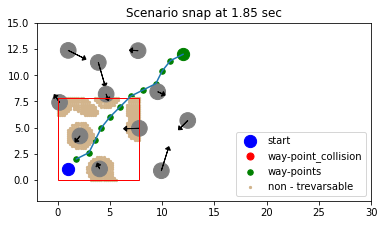

num way_points after graph 13
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


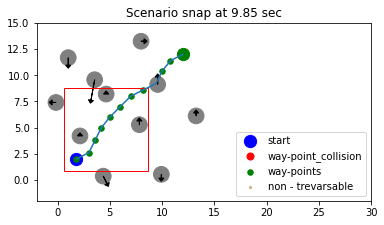

Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


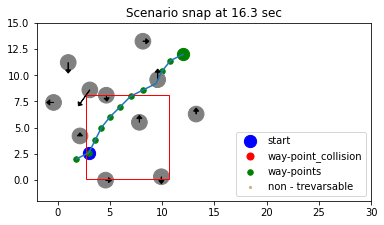

Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


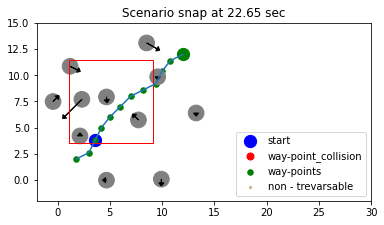

Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


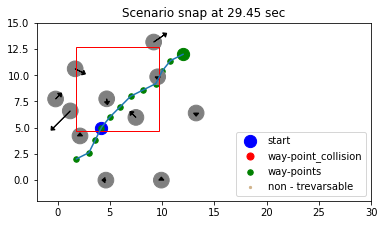

collision detected =============================================================
[6.         7.         0.78539816]
rescan =============================================================


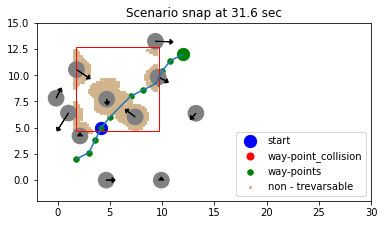

rescan time =  1715.7928943634033
replanning ============================================================================
Expanded nodes  154 Replan time ms 21.805763244628906


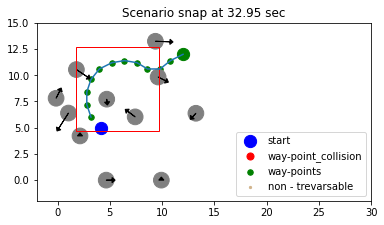

Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


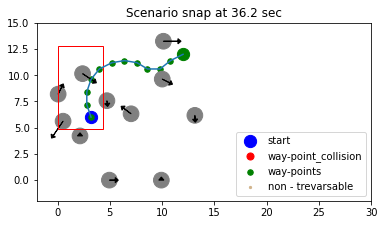

collision detected =============================================================
[2.8        8.4        1.57079633]
rescan =============================================================


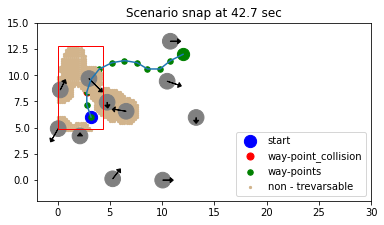

rescan time =  1637.0186805725098
replanning ============================================================================
Failure


In [96]:
#pr.start()
#set_obstacles() #set random position of obstacles.
#gx = 7;gy=7;
obs_dia = 1.5
safe_dis = 0.2
eel_vel = 0.167
pr.stop()
pr.step()
pcount = 0
win = 4
#pr.stop()
start = time.time()
flush_grid()
end = time.time()
print("prep time", (end-start)*1000)
init(False)
update_obmap()
theta = start_pose[2] #get orientation.
rx = start_pose[0] + win*math.cos(theta)
ry = start_pose[1] + win*math.sin(theta) #bring the rectangle such that robot heading covers max area.
rec.x = max(rx-win,0)
rec.y = max(ry-win,0)
rec.width = min(win+rx,13) - rec.x
rec.height = min(win+ry,13) - rec.y
pr.start()
gtime = 0 #make the time zero
time.sleep(1)
update_map() #this updates  the edge_cost first look everywhere
#where is the spheres updates here.
start = time.time()
print("computing shortest distance")
result = compute_shortest_path()
way_nodes = get_waypoints(gu[2])
print("num way_points",len(way_nodes))
print(result)
end = time.time()
print((end-start)*1000)


if(not result[0]):
    print("failure")
    pr.stop()
else:
    print("Expanded nodes ",result[1])
    plot_graph()
    print("num way_points after graph",len(way_nodes))
#plt.savefig('Trajectory_1')
    win =4
    run_robot()
    pr.stop()



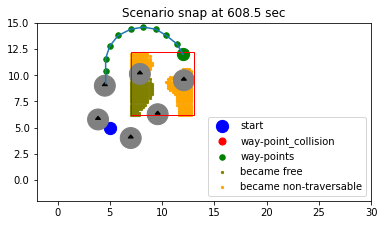

In [76]:
pr.step()
#update_obmap()
start_pose = [5,5,math.pi/4]
update_map()
plot_graph()

In [77]:
len(grid)

75

In [184]:
def plot_obsmap():
    
    global spheres_pos,spheres_vel,start_pose,safe_dis,eel_vel

    fig = plt.figure()
    axes = fig.add_subplot(111)
    #draw obstacles
    
    xc = []
    yc = []
    for rr in range(75):
        for cc in range(75):
            n = grid[rr][cc][0]
            if(check_collision(n)):
                state = n.state
                xc.append(state[0])
                yc.append(state[1])
    
    
    for pos,vel in zip(spheres_pos,spheres_vel):
        #pos = sphere.get_position()
        circle = plt.Circle((pos[0], pos[1]), obs_dia/2, color='gray')
        axes.add_patch(circle)
        #vel = sphere.get_velocity()
        axes.arrow(pos[0], pos[1],vel[0]*10,vel[1]*10, head_width=0.5, head_length=0.3, fc='k', ec='k')
    
    #print("rectangle is ",rec)
    
   

    #print("len xo",len(xo))
    
    #print("in plot",xo)
    axes.scatter([start_pose[0]],[start_pose[1]],150,'blue',label= 'start')
    axes.scatter([12],[12],150,'green',label= 'Goal')
    axes.scatter(xc,yc,10,'tan',label= 'colliding')
    print(start_pose)
    
    axes.set_xlim([-2,30])
    axes.set_ylim([-2,15])
    leg = axes.legend(loc ="lower right");
    axes.set_aspect(aspect=1)
    #plt.title("Eel_vel  = "+str(round(eel_vel,2)))
    plt.title("Safe_dis  = "+str(round(safe_dis,2)))
    plt.savefig("Safe_dis/"+str(int(safe_dis*10)))
    plt.show()
    

In [155]:
round(2.22222,2)

2.22

In [120]:
for ss in spheres_vel:
    ss[0]=0
    ss[1]=0
    ss[2]=0

1
[0, 0, 0.7853981633974483]


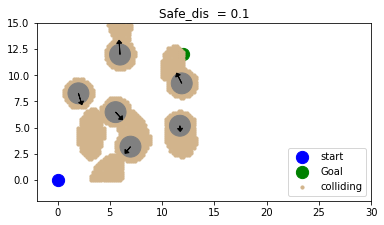

2
[0, 0, 0.7853981633974483]


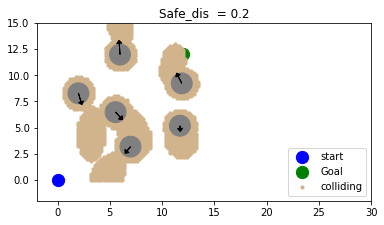

3
[0, 0, 0.7853981633974483]


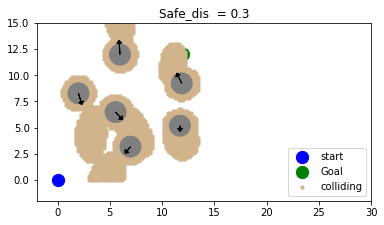

4
[0, 0, 0.7853981633974483]


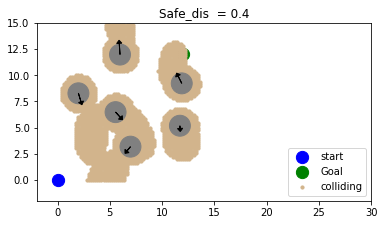

5
[0, 0, 0.7853981633974483]


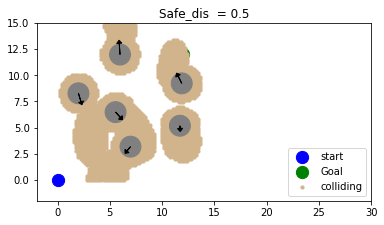

6
[0, 0, 0.7853981633974483]


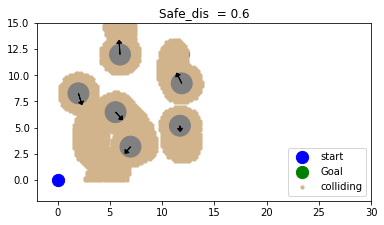

7
[0, 0, 0.7853981633974483]


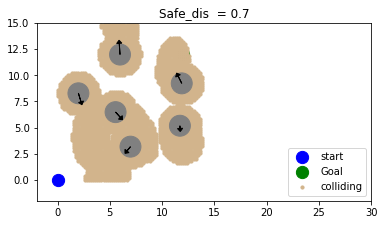

8
[0, 0, 0.7853981633974483]


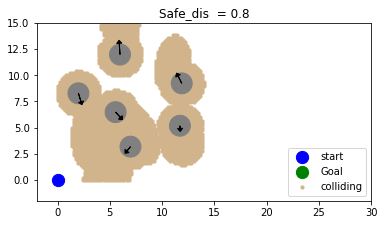

9
[0, 0, 0.7853981633974483]


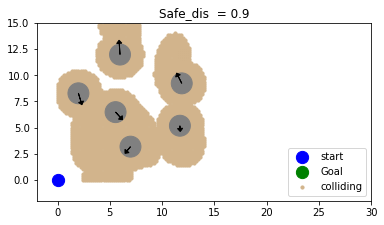

In [185]:
for i in range(1,10):
    safe_dis = i/10
    eel_vel= 0.15
    start_pose = [0,0,math.pi/4]
    print(i)
    update_obmap()
    plot_obsmap()

In [ ]:
for i in range(1,20):
    safe_dis = 0.5
    eel_vel= i*0.01
    start_pose = [0,0,math.pi/4]
    print(i)
    update_obmap()
    plot_obsmap()

In [135]:
for i in range(10):
    safe_dis = float(i)/10
    print(safe_dis)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [56]:
plt.close("all")

In [2]:
sim=False

In [ ]:
pr.shutdown()

In [48]:

# Failure cause
1) First path made is useless and if obstacle changes it would be certain collision
<br> 2) Collision detection prediction seems to have problem. Yes. Replanning is faster. The way-point collision is always more.

# Solution
1) Edge costs are now 1.2. The initial plan is just a straight line.
<br> 2) The collision hull made larger for D*Lite* and smaller for way-points

SyntaxError: invalid syntax (<ipython-input-48-29f5934a3781>, line 2)